# Graph Neural Networks

## GNNs: Leveraging Node Features for Enhanced Performance

<!-- $\bm{x} \in \mathbb{R}^d \rightarrow \bm{h} \in \mathbb{R}^m$ -->

So far, we've focused on graph topology, but graph datasets often include additional features for nodes and edges, such as scores, colors, and words. Incorporating these features is crucial for creating effective embeddings. In this chapter, we'll introduce two new graph datasets: Cora and Facebook Page-Page that their nodes' features are vectors. 

![](img/Node-with-features-Embedding.png)

We'll explore how traditional Neural Networks perform on node features alone and then integrate topological information to develop our first Graph Neural Network (GNN) architecture. By comparing the two approaches, we'll highlight the benefits of combining node features and edges.

By the end of this chapter, you'll learn to implement MLP and GNNs in PyTorch, embedding topological features into node representations to enhance model performance. Topics covered include:

- Introducing graph datasets
- Classifying nodes with vanilla neural networks (MLP)
- Classifying nodes with vanilla graph neural networks (GNNs)


## Introducing graph datasets

The graph datasets we’re going to use in this chapter are richer than Zachary’s Karate Club: they have more nodes, more edges, and include node features. In this section, we will introduce them to give us a good understanding of these graphs and how to process them with PyTorch Geometric. Here 
are the two datasets we will use:

* The Cora dataset
* The Facebook Page-Page dataset

### Cora dataset

Let’s start with the smaller one: the popular Cora dataset from [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html).
The Cora dataset is the most popular dataset for node classification in the scientific literature. It represents a network of 2,708 publications, where each connection is a 
reference. Each publication is described as a binary vector of 1,433 unique words, where 0 and 1 indicate the absence or presence of the corresponding word, respectively. This representation is also called a binary bag of words in natural language processing. Our goal is to classify each node into one of seven categories.

The following figure is a plot of the Cora dataset made with [yEd Live](https://www.yworks.com/yed-live/). Nodes are corresponding to papers. Some papers are so interconnected that they form clusters. These clusters should be easier to classify than poorly connected nodes.

![](img/CoraBalloons.png)


Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).


In [1]:
import torch
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()):
    %pip install -q  torch-geometric==2.2.0 torch-scatter~=2.1.0 torch-sparse~=0.6.16 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

# !pip install -q  torch-geometric==2.2.0 torch-scatter~=2.1.0 torch-sparse~=0.6.16 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
!pip show torch-geometric

Name: torch_geometric
Version: 2.4.0
Summary: Graph Neural Network Library for PyTorch
Home-page: 
Author: 
Author-email: Matthias Fey <matthias@pyg.org>
License: 
Location: d:\programdata\anaconda3\envs\pth\lib\site-packages
Requires: jinja2, numpy, psutil, pyparsing, requests, scikit-learn, scipy, tqdm
Required-by: 


In [3]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root="../../data", name="Cora")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')

print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

d:\ProgramData\Anaconda3\envs\pth\lib\site-packages\torch_geometric\typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
d:\ProgramData\Anaconda3\envs\pth\lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Dataset: Cora()
---------------
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7

Graph:
------
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Edges are directed: False
Graph has isolated nodes: False
Has self-loops: False
Is undirected: True


The different subjects (classes) are:

- 'Case_Based',
- 'Genetic_Algorithms',
- 'Neural_Networks',
- 'Probabilistic_Methods',
- 'Reinforcement_Learning',
- 'Rule_Learning',
- 'Theory'


A typical ML challenges with this dataset in mind:

- label prediction: predict the subject of a paper (node) on the basis of the surrounding node data and the structure of the graph
- edge prediction: given node data, can one predict the papers that should be cited?

In [4]:
import pandas as pd

df_x = pd.DataFrame(data.x.numpy())
df_x['label'] = pd.DataFrame(data.y)
df_x

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2704,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


### Classifying nodes with vanilla neural networks (MLPs)

Compared to Zachary’s Karate Club, these two datasets include a new type of information: node features. They provide additional information about the nodes in a graph, such as a user’s age, gender, or interests in a social network. In a vanilla neural network (also called multilayer perceptron), these embeddings are directly used in the model to perform downstream tasks such as node classification.
In this section, we will consider node features as a regular tabular dataset. We will train a simple neural network on this dataset to classify our nodes. *Note that this architecture does not take into account the topology of the network*. We will try to fix this issue in the next section and compare our results

If you’re familiar with machine learning, you probably recognize a typical dataset with data and labels. We can develop a simple Multilayer Perceptron (MLP) and train it on data.x with the labels provided by data.y.
Let’s create our own MLP class with four methods:

- __init__() to initialize an instance
- forward() to perform the forward pass
- fit() to train the model
- test() to evaluate it

TensorFlow and PyTorch are two famouse deep learning libraries. The [deep learning course](https://fum-cs.github.io/dl-fall-2023/) of FUM-CS at Fall 2023 was based on TensorFlow, and in [Fall 2024](https://fum-cs.github.io/dl-fall-2024), PyTorch is used in the mentioned course.
The code here are based on PyTorch.

In [5]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [6]:
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

In [7]:
# Create MLP model
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)

# Train
mlp.fit(data, epochs=100)

# Test
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=7, bias=True)
)
Epoch   0 | Train Loss: 1.959 | Train Acc: 14.29% | Val Loss: 2.00 | Val Acc: 12.40%
Epoch  20 | Train Loss: 0.110 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 49.40%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.44 | Val Acc: 51.00%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 53.80%
Epoch  80 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.37 | Val Acc: 55.40%
Epoch 100 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.34 | Val Acc: 54.60%

MLP test accuracy: 53.40%


## Classifying nodes with Vanilla Graph Neural Network

A Graph Neural Network (GNN) is a type of neural network designed to operate on graph-structured data. It learns to represent nodes and edges in a graph through message passing and aggregation techniques. Let's break down a simple GNN architecture, focusing on some core mathematical components, particularly the formulation involving weights.

### Basics of Graph Representation

In a graph $ G = (V, E) $:  

- $ V $ is the set of nodes (vertices), $|V|=N$.  
- $ E $ is the set of edges connecting these nodes.  

### Node Features  

Each node $ i \in V $ has a feature vector $ \mathbf{x}_i $ of dimension $ d $. If there are $ N $ nodes in the graph, we can represent the features of all nodes as a feature matrix $ \mathbf{X} $:  

$$  
\mathbf{X} \in \mathbb{R}^{N \times d}  
$$  

### Weight Matrix  

In GNNs, the weights are shared across all nodes, which is a key aspect that allows the model to generalize to different sizes and structures of graphs. The weight matrix $ \mathbf{W} \in \mathbb{R}^{d \times m} $ transforms the feature dimension from $ d $ to $ m $ (the output dimension).  

### Node Representation Calculation  

For a single node $ i $, the new representation after applying the weight matrix can be given as:  

$$  
\mathbf{h}_i = \mathbf{W}^T\mathbf{x}_i   
$$  

Where:  
- $ \mathbf{h}_i \in \mathbb{R}^{m} $ is the new representation of node $ i $.  
- $ \mathbf{x}_i \in \mathbb{R}^{d} $ is the feature vector of node $ i $.  
- $ \mathbf{W} \in \mathbb{R}^{d \times m} $ is the weight matrix.  
- $ \mathbf{X} \in \mathbb{R}^{N \times d}$ is the features of all nodes.
In matrix form for all nodes:  

$$  
\mathbf{H} = \mathbf{X} \mathbf{W}  
$$  

Where:  
- $ \mathbf{H} \in \mathbb{R}^{N \times m} $ is the matrix of new node representations.  

### Weight Sharing  

The weight sharing comes from the fact that each $ \mathbf{x}_i $ is transformed by the same weight matrix $ \mathbf{W} $. This ensures that irrespective of the node being processed, the same transformation is applied, allowing for efficient training on various graph sizes.  

### GNN Layer with Adjacency Matrix  

A simple vanilla GNN layer can use the adjacency matrix $ \mathbf{A} \in \mathbb{R}^{N \times N}$ of the graph. The operation of a GNN Layer are as follows:  

1. **Aggregation**: For each node, aggregate features from its neighbors. This can be done using matrix multiplication with the adjacency matrix:  

$$  
\mathbf{H}^{(l)} = \mathbf{A} \mathbf{H}^{(l-1)}  
$$  

2. **Update**: Apply the weight transformation to the aggregated node features:  

$$  
\mathbf{H}^{(l)} = \sigma(\mathbf{A} \mathbf{H}^{(l-1)} \mathbf{W}^{(l)})  
$$  

Where:
- $ \mathbf{H}^{(l)} $ represents the node features at layer $ l $.  
- $ \sigma $ is an activation function (e.g., ReLU).  
- $ \mathbf{W}^{(l)} $ is the weight matrix for layer $ l $. 
- $ \mathbf{H}^{(0)} = X$. 


This operation allows each node to learn from its neighbors and update its representation iteratively across multiple layers.  

For $l=1$, we have:

$$  
\mathbf{H}^{(1)} = \sigma(\mathbf{A} \mathbf{X} \mathbf{W}^{(0)})  
$$ 

Where:
 $\mathbf{A} \in \mathbb{R}^{N \times N}, \mathbf{X} \in \mathbb{R}^{N \times d}, \mathbf{W}^{(0)} \in \mathbb{R}^{d \times m} \rightarrow \mathbf{H}^{(1)}\in \mathbb{R}^{N \times m}$

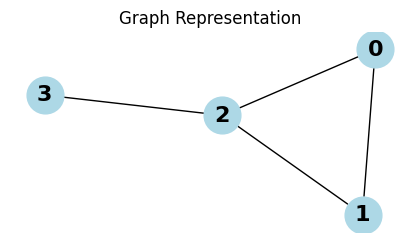

A:
[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]
Initial Node Features (H_prev):
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
Aggrgation A[0,:]*H 
[11 13 15]

Aggregated Features (H_agg):
[[11 13 15]
 [ 8 10 12]
 [15 18 21]
 [ 7  8  9]]

Updated Node Features (H_new):
[[26 28]
 [20 22]
 [36 39]
 [16 17]]


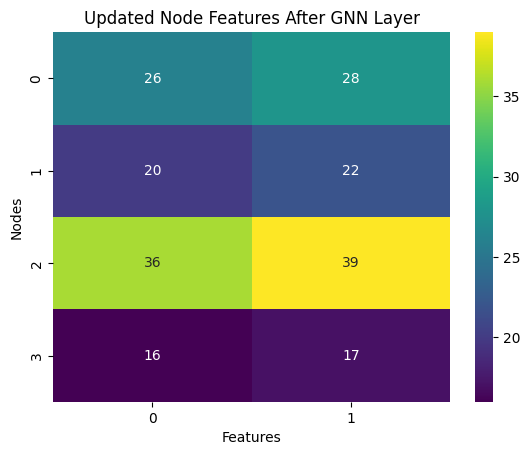

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Set random seed for reproducibility
np.random.seed(42)

# Define the adjacency matrix for a small graph (4 nodes)
A = np.array([[0, 1, 1, 0],
              [1, 0, 1, 0],
              [1, 1, 0, 1],
              [0, 0, 1, 0]])

# Visualize the graph
G = nx.from_numpy_matrix(A)
pos = nx.spring_layout(G)

plt.figure(figsize=(4, 2))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=16, font_weight='bold', arrows=True)
plt.title("Graph Representation")
plt.show()

# Define initial node features (4 nodes, 3 features each) with integer values
H_prev = np.array([[1, 2, 3],   # Features for node 0
                   [4, 5, 6],   # Features for node 1
                   [7, 8, 9],   # Features for node 2
                   [10, 11, 12]])  # Features for node 3

# Define a weight matrix for transformation (3 input features, 2 output features) with integer values
W = np.array([[1, 0],  # Weights for feature 1
              [0, 1],  # Weights for feature 2
              [1, 1]]) # Weights for feature 3

# Aggregation step
H_agg = A @ H_prev  # Shape will be (4, 3)

# Update step without activation
H_new = H_agg @ W  # Apply weight transformation

print("A:")
print(A)
# Print results
print("Initial Node Features (H_prev):")
print(H_prev)

print("Aggrgation A[0,:]*H ")
print(A[0,:]@H_prev)

print("\nAggregated Features (H_agg):")
print(H_agg)
print("\nUpdated Node Features (H_new):")
print(H_new)

# Visualizing the updated features
sns.heatmap(H_new, annot=True, fmt="d", cmap='viridis')
plt.title("Updated Node Features After GNN Layer")
plt.xlabel("Features")
plt.ylabel("Nodes")
plt.show()

Look at 'The simplest GNN' section of [A Gentle Introduction to Graph Neural Networks](https://gta-lab.github.io/gnn-intro/).

In [8]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F

In [9]:
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        hw = self.linear(x)
        ahw = torch.sparse.mm(adjacency, hw)
        return ahw

In [10]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))

data.x.shape, adjacency.shape

(torch.Size([2708, 1433]), torch.Size([2708, 2708]))

In [11]:
class VanillaGNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h)
        self.gnn2 = VanillaGNNLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        ahw = self.gnn1(x, adjacency)
        h = torch.relu(ahw)
        ahw = self.gnn2(h, adjacency)
        return F.log_softmax(ahw, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)

# Train
gnn.fit(data, epochs=100)

# Test
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)
Epoch   0 | Train Loss: 2.039 | Train Acc: 16.43% | Val Loss: 2.10 | Val Acc: 8.80%
Epoch  20 | Train Loss: 0.025 | Train Acc: 100.00% | Val Loss: 2.20 | Val Acc: 74.40%
Epoch  40 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 2.95 | Val Acc: 73.20%
Epoch  60 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 3.04 | Val Acc: 73.80%
Epoch  80 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.96 | Val Acc: 74.20%
Epoch 100 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 2.89 | Val Acc: 74.40%

GNN test accuracy: 75.10%


## Facebook Page-Page dataset

[This webgraph](http://snap.stanford.edu/data/facebook-large-page-page-network.html) is a page-page graph of verified Facebook sites. Nodes represent official Facebook pages while the links are mutual likes between sites. Node features are extracted from the site descriptions that the page owners created to summarize the purpose of the site. This graph was collected through the Facebook Graph API in November 2017 and restricted to pages from 4 categories which are defined by Facebook. These categories are: politicians, governmental organizations, television shows and companies. The task related to this dataset is multi-class node classification for the 4 site categories ([Source of the following graph](https://studentwork.prattsi.org/infovis/labs/facebook-page-page-social-network/)). 

![](img/Facebook-prattsi.jpg)

In [12]:
## Facebook dataset
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root="../../data/Facebook")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


In [13]:
# Dataset
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Adjacency matrix
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

# MLP
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

# GCN
gnn = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)
gnn.fit(data, epochs=100)
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.435 | Train Acc: 19.40% | Val Loss: 1.42 | Val Acc: 19.46%
Epoch  20 | Train Loss: 0.677 | Train Acc: 73.54% | Val Loss: 0.69 | Val Acc: 73.04%
Epoch  40 | Train Loss: 0.581 | Train Acc: 76.63% | Val Loss: 0.63 | Val Acc: 73.74%
Epoch  60 | Train Loss: 0.551 | Train Acc: 78.13% | Val Loss: 0.61 | Val Acc: 75.14%
Epoch  80 | Train Loss: 0.534 | Train Acc: 78.72% | Val Loss: 0.61 | Val Acc: 75.19%
Epoch 100 | Train Loss: 0.522 | Train Acc: 79.26% | Val Loss: 0.61 | Val Acc: 75.59%

MLP test accuracy: 75.42%

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 46.270 | Train Acc: 25.39% | Val Loss: 46.26 | Val Acc: 25.41%
Epoch  20 | Train Loss: 3.429 | 

## Summary  

1. Each node has a feature vector $ \mathbf{x}_i $ of dimension $ d $.  
2. The combined feature matrix for all nodes is $ \mathbf{X} \in \mathbb{R}^{N \times d} $.  
3. A weight matrix $ \mathbf{W} \in \mathbb{R}^{d \times m} $ transforms the features.  
4. The adjacency matrix $ \mathbf{A} $ is used to aggregate neighbors' information.  
5. The new node representations can be calculated iteratively in a GNN layer as:  

$$  
\mathbf{H}^{(l)} = \sigma(\mathbf{A} \mathbf{H}^{(l-1)} \mathbf{W}^{(l)})  
$$  

This framework builds the foundation for more complex operations in GNNs, including additional layers and techniques for handling diverse graph structures.